### Analyzing, visualizing and predicting local states in a localization problem
### Part-4: Predicting Q2 (or the 2nd quantile or 50th percentile) of the local states
In this notebook, similar to the [previous notebook](https://github.com/helalme/UncertaintiesReductionInLocalization/blob/master/2.%20TrainingAndPredictionOfQ1.ipynb) we will use bidirectionl LSTM network for the prediction of Q2 at different timesteps of a localization problem.

#### Loading necessary packages

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


#### Loading the training and test data

In [5]:
series = np.loadtxt('Data/Q2-13to2000grains.txt')
series

array([[ -67.97416667,  -97.88455417, -119.94364583, -137.17708333,
        -150.61236458, -161.62197917, -170.21052083, -177.1741875 ,
        -182.86958333, -187.42820833, -153.0975    , -118.06458333,
         -82.43833333,  -46.39770833,  -10.00321875,   26.78587917,
          63.77811458,  100.96145833,  138.34120833,  175.79875   ],
       [ -37.2917    ,  -54.1217    ,  -66.9537    ,  -77.6823    ,
         -87.2555    ,  -95.9675    , -104.062     , -111.559     ,
        -118.512     , -124.876     ,  -92.567     ,  -59.7992    ,
         -26.599     ,    6.97643   ,   40.8051    ,   74.9961    ,
         109.402     ,  144.096     ,  179.02      ,  214.112     ],
       [ -29.39625   ,  -42.990625  ,  -53.515625  ,  -62.59125   ,
         -70.678125  ,  -77.98      ,  -84.750625  ,  -91.135     ,
         -97.19      , -102.95      ,  -70.920625  ,  -38.7325    ,
          -6.3613125 ,   26.22      ,   58.98625   ,   92.02625   ,
         125.325     ,  158.875     ,  192.625

#### Visualize the training set

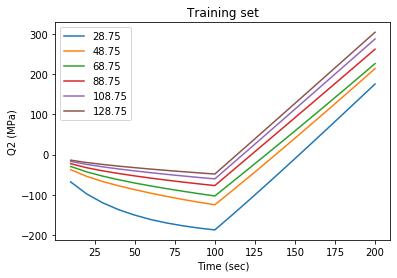

In [6]:
time=range(10,201,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
#plt.plot(time, series[6],  label='148.75')
#plt.plot(time, series[7],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('Q2 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

#### Like previous notebook for Q1, let preprocess and start training with 6 sets. 

In [8]:
slope1=(series[0][10]-series[0][9])/10.0
slope2=(series[1][10]-series[1][9])/10.0
slope3=(series[2][10]-series[2][9])/10.0
slope4=(series[3][10]-series[3][9])/10.0
slope5=(series[4][10]-series[4][9])/10.0
slope6=(series[5][10]-series[5][9])/10.0

print(slope1, slope2, slope3, slope4, slope5,slope6)
print((slope1+slope2+slope3+slope4+slope5+slope6)/6)

3.433070833333301 3.230900000000001 3.202937499999899 3.37325 3.44525 3.4987500000000002
3.3640263888888673


In [9]:
#To make a meaningful sequence, sloples should be sequencial
#Rearranging slops as :slope2, slope3, slope4, slope1, slope5, slope6, ... for dataset 1, 2, 3, 4 ,.....
slope=[slope3, slope2, slope4, slope1]
for i in range(0,4):
    for j in range(10,20):
        series[i][j]=series[i][j-1]+slope[i]*10

        

#### Lets visualize the training sets after the preprocessing

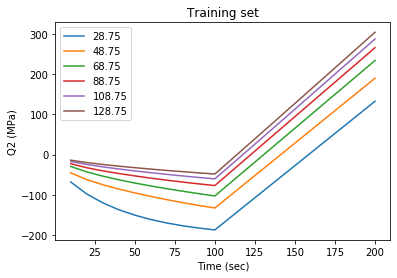

In [11]:
time=range(10,201,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')

plt.xlabel('Time (sec)')
plt.ylabel('Q2 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

In [10]:
# Shifting down the 2nd set in order to look like a good sequence
series[1]=series[1]-8

#### prepare the training Sequence with 6 sets for 2-to-1 bidirectional LSTM architecture

In [35]:
Xtrain1=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]],[series[3],series[4]]])
Ytrain1 = np.array([series[2],series[3],series[4],series[5]]) 


#### Start the training

In [39]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.12  ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,activation='relu', return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain1, Ytrain1, epochs=1000, callbacks=[callbacks]) #, validation_data=(Xtest, Ytest)

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 3s 770ms/sample - loss: 16465.4707
Epoch 2/1000
4/4 [==============================] - 0s 0s/sample - loss: 13399.4609
Epoch 3/1000
4/4 [==============================] - 0s 2ms/sample - loss: 9801.6523
Epoch 4/1000
4/4 [==============================] - 0s 3ms/sample - loss: 5805.2559
Epoch 5/1000
4/4 [==============================] - 0s 2ms/sample - loss: 4672.1982
Epoch 6/1000
4/4 [==============================] - 0s 2ms/sample - loss: 3183.0923
Epoch 7/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1756.6748
Epoch 8/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1100.5511
Epoch 9/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1265.6483
Epoch 10/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1292.2886
Epoch 11/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1030.2990
Epoch 12/1000
4/4 [==============================] -

Epoch 99/1000
4/4 [==============================] - 0s 3ms/sample - loss: 93.9997
Epoch 100/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.4961
Epoch 101/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.3635
Epoch 102/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.4353
Epoch 103/1000
4/4 [==============================] - 0s 3ms/sample - loss: 88.5415
Epoch 104/1000
4/4 [==============================] - 0s 2ms/sample - loss: 86.1521
Epoch 105/1000
4/4 [==============================] - 0s 3ms/sample - loss: 87.6840
Epoch 106/1000
4/4 [==============================] - 0s 3ms/sample - loss: 87.6008
Epoch 107/1000
4/4 [==============================] - 0s 2ms/sample - loss: 88.2959
Epoch 108/1000
4/4 [==============================] - 0s 3ms/sample - loss: 88.5127
Epoch 109/1000
4/4 [==============================] - 0s 2ms/sample - loss: 86.3009
Epoch 110/1000
4/4 [==============================] - 0s 2ms/sample - loss: 8

Epoch 197/1000
4/4 [==============================] - 0s 2ms/sample - loss: 40.7381
Epoch 198/1000
4/4 [==============================] - 0s 3ms/sample - loss: 39.5309
Epoch 199/1000
4/4 [==============================] - 0s 3ms/sample - loss: 38.3271
Epoch 200/1000
4/4 [==============================] - 0s 2ms/sample - loss: 37.1319
Epoch 201/1000
4/4 [==============================] - 0s 3ms/sample - loss: 35.9575
Epoch 202/1000
4/4 [==============================] - 0s 2ms/sample - loss: 34.7947
Epoch 203/1000
4/4 [==============================] - 0s 2ms/sample - loss: 33.6444
Epoch 204/1000
4/4 [==============================] - 0s 3ms/sample - loss: 32.5117
Epoch 205/1000
4/4 [==============================] - 0s 2ms/sample - loss: 31.4490
Epoch 206/1000
4/4 [==============================] - 0s 2ms/sample - loss: 30.3608
Epoch 207/1000
4/4 [==============================] - 0s 3ms/sample - loss: 29.2936
Epoch 208/1000
4/4 [==============================] - 0s 2ms/sample - loss: 

Epoch 296/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.7963
Epoch 297/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.7477
Epoch 298/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.7074
Epoch 299/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.6625
Epoch 300/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.6289
Epoch 301/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.5831
Epoch 302/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.5510
Epoch 303/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.5091
Epoch 304/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.4757
Epoch 305/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.4424
Epoch 306/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.4088
Epoch 307/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.3805
Epoc

Epoch 395/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3838
Epoch 396/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3797
Epoch 397/1000
4/4 [==============================] - 0s 1ms/sample - loss: 0.3759
Epoch 398/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3730
Epoch 399/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3689
Epoch 400/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3658
Epoch 401/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3630
Epoch 402/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3590
Epoch 403/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3567
Epoch 404/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3547
Epoch 405/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3498
Epoch 406/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3473
Epoc

Epoch 494/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1864
Epoch 495/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1854
Epoch 496/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1844
Epoch 497/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1832
Epoch 498/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1821
Epoch 499/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1811
Epoch 500/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1801
Epoch 501/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1790
Epoch 502/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1780
Epoch 503/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1770
Epoch 504/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1761
Epoch 505/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1751
Epoc

#### Predict and compare the 7th set, looks excellent 

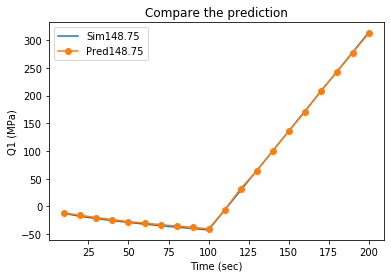

In [40]:
x5=np.array([[series[4],series[5]]])
y5=model.predict(x5)

time=range(10,201,10)

#lt.plot(time, series[2],  label='68.75')
#plt.plot(time, series[3],  label='88.75')
#plt.plot(time, series[4],  label='108.75')
#plt.plot(time, series[5],  label='128.75')
plt.plot(time, series[6],  label='Sim148.75')
plt.plot(time, y5[0], 'o-', label='Pred148.75')

plt.xlabel('Time (sec)')
plt.ylabel('Q1 (MPa)')
plt.title('Compare the prediction')
plt.legend()

plt.show()

#### Compare value by value, relative error is 1 to 2 MPa only

In [41]:
print(series[6])
print(y5[0])

[-12.77125  -17.96     -22.05625  -25.65375  -28.92375  -31.9725
 -34.82125  -37.49375  -40.02375  -42.43875   -6.868125  28.765
  64.4525   100.1725   135.9125   171.65     207.35     243.0625
 278.775    314.5125  ]
[-11.775969  -16.066143  -20.110565  -23.802212  -27.45151   -29.93836
 -32.964733  -35.382317  -37.617023  -40.547672   -6.1688113  32.106888
  64.08639    99.93662   135.7904    170.25491   208.55275   242.38875
 277.66763   312.40866  ]


#### Observe the training losses curve

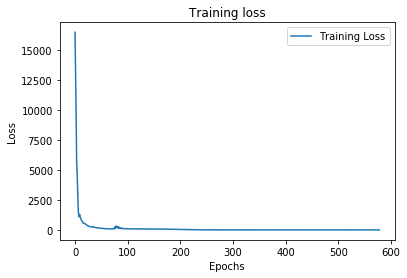

In [42]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[0:], loss[0:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Lets continue training for the prediction of 8th set

In [44]:
Xtrain2=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]],[series[3],series[4]],[series[4],series[5]]])
Ytrain2 = np.array([series[2],series[3],series[4],series[5],y5[0]])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.12   ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,activation='relu', return_sequences=True, input_shape=(2, 20))),#
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),  #
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain2, Ytrain2, epochs=1000, callbacks=[callbacks]) #, validation_data=(Xtest, Ytest)



Train on 5 samples
Epoch 1/1000
5/5 [==============================] - 3s 637ms/sample - loss: 14760.5996
Epoch 2/1000
5/5 [==============================] - 0s 3ms/sample - loss: 12726.8545
Epoch 3/1000
5/5 [==============================] - 0s 3ms/sample - loss: 8964.4609
Epoch 4/1000
5/5 [==============================] - 0s 3ms/sample - loss: 7347.4795
Epoch 5/1000
5/5 [==============================] - 0s 2ms/sample - loss: 5060.1807
Epoch 6/1000
5/5 [==============================] - 0s 2ms/sample - loss: 3473.7075
Epoch 7/1000
5/5 [==============================] - 0s 1ms/sample - loss: 2393.7551
Epoch 8/1000
5/5 [==============================] - 0s 1ms/sample - loss: 1560.7795
Epoch 9/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1033.7620
Epoch 10/1000
5/5 [==============================] - 0s 2ms/sample - loss: 807.3802
Epoch 11/1000
5/5 [==============================] - 0s 1ms/sample - loss: 643.7906
Epoch 12/1000
5/5 [==============================] - 

Epoch 100/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.3888
Epoch 101/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.3311
Epoch 102/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.2719
Epoch 103/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.2416
Epoch 104/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.1657
Epoch 105/1000
5/5 [==============================] - 0s 3ms/sample - loss: 1.1336
Epoch 106/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0806
Epoch 107/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0489
Epoch 108/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0226
Epoch 109/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9785
Epoch 110/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9518
Epoch 111/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9002
Epoc

Epoch 199/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4869
Epoch 200/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4862
Epoch 201/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4855
Epoch 202/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4848
Epoch 203/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4842
Epoch 204/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4835
Epoch 205/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4829
Epoch 206/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4823
Epoch 207/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4817
Epoch 208/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4810
Epoch 209/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4805
Epoch 210/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4799
Epoc

Epoch 298/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4485
Epoch 299/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4482
Epoch 300/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4479
Epoch 301/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4476
Epoch 302/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4473
Epoch 303/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4471
Epoch 304/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4468
Epoch 305/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4465
Epoch 306/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4462
Epoch 307/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4459
Epoch 308/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4456
Epoch 309/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4453
Epoc

Epoch 397/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4202
Epoch 398/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4199
Epoch 399/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4196
Epoch 400/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4193
Epoch 401/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4190
Epoch 402/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4188
Epoch 403/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4185
Epoch 404/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4182
Epoch 405/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4179
Epoch 406/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4177
Epoch 407/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4174
Epoch 408/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4171
Epoc

Epoch 496/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3940
Epoch 497/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3938
Epoch 498/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3935
Epoch 499/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3933
Epoch 500/1000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3930
Epoch 501/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3928
Epoch 502/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3925
Epoch 503/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3923
Epoch 504/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3920
Epoch 505/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3918
Epoch 506/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3915
Epoch 507/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3913
Epoc

Epoch 595/1000
5/5 [==============================] - 0s 2ms/sample - loss: 113.0907
Epoch 596/1000
5/5 [==============================] - 0s 2ms/sample - loss: 43.6691
Epoch 597/1000
5/5 [==============================] - 0s 2ms/sample - loss: 2.4761
Epoch 598/1000
5/5 [==============================] - 0s 2ms/sample - loss: 50.7850
Epoch 599/1000
5/5 [==============================] - 0s 2ms/sample - loss: 75.0890
Epoch 600/1000
5/5 [==============================] - 0s 2ms/sample - loss: 7.7026
Epoch 601/1000
5/5 [==============================] - 0s 2ms/sample - loss: 24.6912
Epoch 602/1000
5/5 [==============================] - 0s 2ms/sample - loss: 60.6052
Epoch 603/1000
5/5 [==============================] - 0s 2ms/sample - loss: 6.6268
Epoch 604/1000
5/5 [==============================] - 0s 2ms/sample - loss: 23.5539
Epoch 605/1000
5/5 [==============================] - 0s 2ms/sample - loss: 43.6872
Epoch 606/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.

Epoch 694/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3724
Epoch 695/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3746
Epoch 696/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3723
Epoch 697/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3717
Epoch 698/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3731
Epoch 699/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3700
Epoch 700/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3715
Epoch 701/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3708
Epoch 702/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3693
Epoch 703/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3707
Epoch 704/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3688
Epoch 705/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3690
Epoc

Epoch 793/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3496
Epoch 794/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3494
Epoch 795/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3492
Epoch 796/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3490
Epoch 797/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3488
Epoch 798/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3486
Epoch 799/1000
5/5 [==============================] - 0s 613us/sample - loss: 0.3484
Epoch 800/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3482
Epoch 801/1000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3480
Epoch 802/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3478
Epoch 803/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3476
Epoch 804/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3474
Ep

Epoch 892/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3312
Epoch 893/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3310
Epoch 894/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3308
Epoch 895/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3307
Epoch 896/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3305
Epoch 897/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3303
Epoch 898/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3301
Epoch 899/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3300
Epoch 900/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3298
Epoch 901/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3296
Epoch 902/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3294
Epoch 903/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3293
Epoc

Epoch 991/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3149
Epoch 992/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3148
Epoch 993/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3146
Epoch 994/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3145
Epoch 995/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3143
Epoch 996/1000
5/5 [==============================] - 0s 4ms/sample - loss: 0.3142
Epoch 997/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3140
Epoch 998/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3138
Epoch 999/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3137
Epoch 1000/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3135


#### Compare the prediction of the 8th set, also looks great with minor relative errors

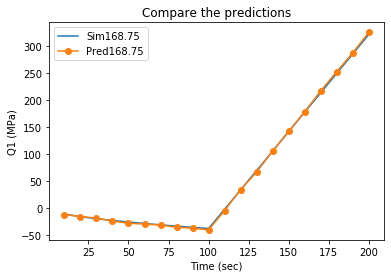

In [45]:
x6=np.array([[series[5],y5[0]]])
y6=model.predict(x6)

time=range(10,201,10)

#plt.plot(time, series[6],  label='Sim148.75')  
plt.plot(time, series[7],  label='Sim168.75')
#plt.plot(time, y5[0], 'o-', label='Pred148.75')
plt.plot(time, y6[0], 'o-', label='Pred168.75')
plt.xlabel('Time (sec)')
plt.ylabel('Q1 (MPa)')
plt.title('Compare the predictions')
plt.legend()

plt.show()

#### So we have seen for the prediction of both Q1 and Q2 that 6 sets of training data and slight preprocessing is necessary to get smooth training and great prediction